## Load the necessary modules

Zipline only works with an older version of pandas. It is necessary to downgrade to the version of pandas that is 0.22.0

In [98]:
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import zipline
import numpy as np
from zipline.api import order, record, symbols
from zipline.assets import Equity, Future
from zipline import run_algorithm
from collections import OrderedDict
from datetime import datetime

## Load and Prelimenary Analysis of Data

In [97]:
# Stock in our portfolio
stocks  = ["AAPL", "AMZN", "BA", "FB", "GOOG", "MA", "MSFT", "NVDA", "UNH", "V"]

# Calculate the weekly and yearly returns for stocks
stockList = []
# Creates a dataframe from our CSV
for stock in stocks:
    df = pd.read_csv("{}.csv".format(stock), index_col =0, parse_dates=['Date'])
    stockList.append(df)
stockdf = pd.concat(stockList, keys=stocks)
stockdf = stockdf.reset_index()
stockdf.rename(index=str, columns={"level_0":"ticker"}, inplace=True)
# To computer the covariance matrix , turn data into long format with pivot table
datawide = pd.pivot_table(stockdf, values='adj close', index=['Date'], columns='ticker')

ticker,AAPL,AMZN,BA,FB,GOOG,MA,MSFT,NVDA,UNH,V
Date,,,,,,,,,,
2018-01-01,163.62,1450.89,343.84,186.89,1169.94,167.56,92.65,244.86,232.74,123.00
2018-02-01,174.07,1512.45,351.44,178.32,1104.73,174.54,91.44,241.08,222.30,121.73
2018-03-01,164.63,1447.34,319.70,159.79,1031.79,173.94,89.42,230.85,210.35,118.65
2018-04-01,162.16,1566.13,325.24,172.00,1017.33,177.03,91.63,224.18,233.14,125.85
2018-05-01,183.36,1629.62,343.38,191.78,1084.99,189.07,96.84,251.39,238.18,129.65
2018-06-01,182.33,1699.80,328.78,194.32,1115.65,195.43,97.03,236.29,241.95,131.58
2018-07-01,187.44,1777.44,349.15,172.58,1217.26,196.91,104.38,244.23,250.61,135.84
2018-08-01,224.22,2012.71,335.91,175.73,1218.19,214.64,110.54,279.96,265.69,145.93
2018-09-01,223.14,2003.00,366.24,164.46,1193.47,221.66,112.98,280.45,263.30,149.33


In [101]:
returns = np.log(datawide).diff()
returns

ticker,AAPL,AMZN,BA,FB,GOOG,MA,MSFT,NVDA,UNH,V
Date,,,,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.061911,0.041554,0.021863,-0.046941,-0.057352,0.040812,-0.013146,-0.015558,-0.045894,-0.010379
2018-03-01,-0.055757,-0.044003,-0.094656,-0.109719,-0.068306,-0.003444,-0.022339,-0.043361,-0.055255,-0.025627
2018-04-01,-0.015117,0.078880,0.017180,0.073634,-0.014114,0.017609,0.024414,-0.029319,0.102866,0.058913
2018-05-01,0.122868,0.039739,0.054274,0.108854,0.064389,0.065798,0.055301,0.114556,0.021388,0.029748
2018-06-01,-0.005633,0.042164,-0.043449,0.013157,0.027866,0.033085,0.001960,-0.061946,0.015704,0.014777
2018-07-01,0.027641,0.044664,0.060113,-0.118645,0.087165,0.007545,0.073018,0.033051,0.035167,0.031863
2018-08-01,0.179169,0.124308,-0.038658,0.018088,0.000764,0.086215,0.057339,0.136536,0.058432,0.071649
2018-09-01,-0.004828,-0.004836,0.086446,-0.066281,-0.020501,0.032182,0.021833,0.001749,-0.009036,0.023032


## Make data compatible with Zipline

In [24]:
# Store the different datasets
data = {}

# Iterate to load stock data from csv
for stock in stocks:
    data[stock] = pd.read_csv("{}.csv".format(stock), index_col =0, parse_dates=['Date'])
    data[stock] = data[stock][["open","high","low","close","adj close","volume"]]

In [25]:
# Convert data to panel
StockPrice = pd.Panel(data)
StockPrice.minor_axis = ["open","high","low","close","adj close","volume"]
StockPrice.major_axis = StockPrice.major_axis.tz_localize(pytz.utc)
print(StockPrice)

<class 'pandas.core.panel.Panel'>
Dimensions: 10 (items) x 12 (major_axis) x 6 (minor_axis)
Items axis: AAPL to V
Major_axis axis: 2018-01-01 00:00:00+00:00 to 2018-12-01 00:00:00+00:00
Minor_axis axis: open to volume


Text(0, 0.5, 'Price in $')

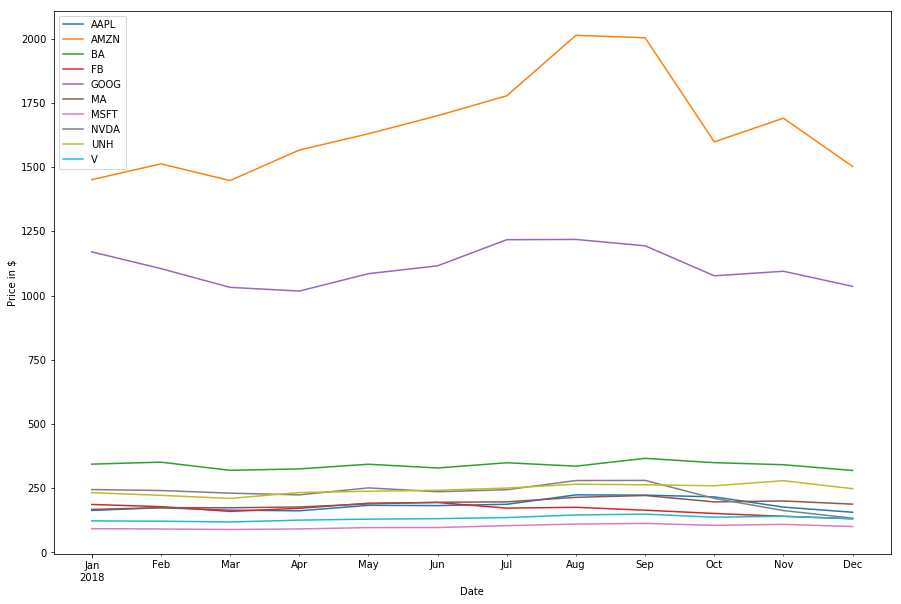

In [26]:
plt.figure(figsize=(15,10))
for stock in stocks:
    data[stock]['adj close'].plot()
plt.legend(stocks)
plt.ylabel("Price in $")

In [ ]:
# I dont think this does anything
%load_ext zipline

## Set constraints 

In [ ]:
# Constraints for our algorithm
initial_capital = 10000
# Time frame for our algorithm
startDate = datetime(2018,1,1,0,0,0,0,pytz.utc)
endDate = datetime(2018,12,1,0,0,0,0,pytz.utc)
# Cost per trade will be 4.95 just because of my brokerage
DEFAULT_MINIMUM_COST_PER_EQUITY_TRADE = 4.95
DEFAULT_MINIMUM_COST_PER_FUTURE_TRADE = 4.95


## Run Algorithm

In [ ]:
# Define necessary two functions to run algorithm
def initialize(context):
    context.assest = symbols('GOOG')
    
def handle_data(context, data):
    order(symbol('GOOG'),10)
    record(GOOG = data.current(symbol('GOOG'),'price'))



In [ ]:
perf = zipline.run_algorithm(start= startDate,
                            end= endDate,
                            initialize=initialize,
                            data_frequency='daily',
                            capital_base= initial_capital,
                            handle_data=handle_data,
                            data=StockPrice)
perf.head(5)